**Nota importante**: La asignación de etiquetas Level2 se ha realizado combinando:
- paneles de marcadores derivados del Inflammation PBMCs Atlas,
- análisis de expresión diferencial 1-vs-rest por cluster L2,
y
- criterios biológicos consensuados con la tutora del TFM.

# 09 – Ensamblado del objeto principal anotado y figuras globales

In [1]:
from pathlib import Path
import json

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

print("Scanpy:", sc.__version__)
print("AnnData:", ad.__version__)

Scanpy: 1.11.5
AnnData: 0.12.6


C:\Users\Coni\AppData\Local\Temp\ipykernel_11092\1154666483.py:9: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Scanpy:", sc.__version__)
C:\Users\Coni\AppData\Local\Temp\ipykernel_11092\1154666483.py:10: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print("AnnData:", ad.__version__)


In [2]:
### Celda 5 — Código: rutas del proyecto y configuración básica

# Detectamos la carpeta raíz del proyecto asumiendo que este notebook está en "notebooks/"
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

AI_PACKAGE_DIR      = PROJECT_ROOT / "AI_Package"
MARKERS_DIR         = AI_PACKAGE_DIR / "markers"
DATA_PROCESSED_DIR  = PROJECT_ROOT / "data_processed"
LINEAGES_DIR        = DATA_PROCESSED_DIR / "lineages"
FIGURES_DIR         = PROJECT_ROOT / "figures"

DATA_PROCESSED_DIR.mkdir(exist_ok=True)
LINEAGES_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

print("Directorio del notebook:", NOTEBOOK_DIR)
print("Raíz del proyecto:", PROJECT_ROOT)
print("Carpeta AI_Package:", AI_PACKAGE_DIR)
print("Carpeta markers:", MARKERS_DIR)
print("Carpeta data_processed:", DATA_PROCESSED_DIR)
print("Carpeta lineages:", LINEAGES_DIR)
print("Carpeta figures:", FIGURES_DIR)

# Leemos MANIFEST.json para obtener claves estándar
manifest_path = AI_PACKAGE_DIR / "MANIFEST.json"
if manifest_path.exists():
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
else:
    manifest = {}
    print("\n[AVISO] No se ha encontrado MANIFEST.json; se usarán valores por defecto.")

EMB_KEY = manifest.get("keys", {}).get("EMB_KEY", "X_pca_harmony")
NBR_KEY = manifest.get("keys", {}).get("NBR_KEY", "harmony")
UMAP_KEY = manifest.get("keys", {}).get("UMAP_KEY", "X_umap_harmony")

CONFIG = {
    "PROJECT_ROOT": PROJECT_ROOT,
    "AI_PACKAGE_DIR": AI_PACKAGE_DIR,
    "MARKERS_DIR": MARKERS_DIR,
    "DATA_PROCESSED_DIR": DATA_PROCESSED_DIR,
    "LINEAGES_DIR": LINEAGES_DIR,
    "FIGURES_DIR": FIGURES_DIR,
    "MAIN_WITH_L1_PATH": DATA_PROCESSED_DIR / "TFM_CIRRHOSIS_main_with_Level1.h5ad",
    "EMB_KEY": EMB_KEY,
    "NBR_KEY": NBR_KEY,
    "UMAP_KEY": UMAP_KEY,
}

CONFIG

Directorio del notebook: D:\Users\Coni\Documents\TFM_CirrhosIS\notebooks
Raíz del proyecto: D:\Users\Coni\Documents\TFM_CirrhosIS
Carpeta AI_Package: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package
Carpeta markers: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package\markers
Carpeta data_processed: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed
Carpeta lineages: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages
Carpeta figures: D:\Users\Coni\Documents\TFM_CirrhosIS\figures


{'PROJECT_ROOT': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS'),
 'AI_PACKAGE_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package'),
 'MARKERS_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package/markers'),
 'DATA_PROCESSED_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed'),
 'LINEAGES_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed/lineages'),
 'FIGURES_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/figures'),
 'MAIN_WITH_L1_PATH': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed/TFM_CIRRHOSIS_main_with_Level1.h5ad'),
 'EMB_KEY': 'X_pca_harmony',
 'NBR_KEY': 'harmony',
 'UMAP_KEY': 'X_umap_harmony'}

In [3]:
main_with_l1_path = CONFIG["MAIN_WITH_L1_PATH"]

if not main_with_l1_path.exists():
    raise FileNotFoundError(
        f"No se encuentra el objeto global con Level1 en:\n{main_with_l1_path}\n"
        "Asegúrate de haber ejecutado el notebook de Level1 o ajusta la ruta."
    )

adata_main = sc.read_h5ad(main_with_l1_path)
print(adata_main)

# Comprobamos Level1
if "Level1" not in adata_main.obs.columns:
    raise KeyError("No se encontró 'Level1' en adata_main.obs.")

print("\nDistribución de Level1 en el objeto global:")
print(adata_main.obs["Level1"].value_counts())

# Comprobamos que están los embeddings estándar
for key in [CONFIG["EMB_KEY"], CONFIG["UMAP_KEY"]]:
    if key not in adata_main.obsm.keys():
        raise KeyError(f"No se encontró '{key}' en adata_main.obsm.")
    else:
        print(f"Embedding '{key}' presente con forma {adata_main.obsm[key].shape}.")

AnnData object with n_obs × n_vars = 222389 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_r0_2', 'leiden_r0_5', 'leiden_r0_8', 'leiden_L1', 'Level1_auto_suggested', 'Level1'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable

In [4]:
level1_categories = list(adata_main.obs["Level1"].cat.categories) \
    if hasattr(adata_main.obs["Level1"], "cat") \
    else sorted(adata_main.obs["Level1"].unique())

print("Linajes Level1 presentes en el objeto global:")
print(level1_categories)

# Solo estos linajes tienen Level2 detallado (NB07–08 ejecutados):
#   - B
#   - T_and_NK
#   - Mono_and_DC
LINEAGES_WITH_LEVEL2 = ["B", "T_and_NK", "Mono_and_DC"]

# Construimos las rutas esperadas de los archivos de linaje con L2 markers
lineage_paths = {}
print("\nRutas esperadas de objetos por linaje con L2 markers (solo linajes con Level2):")
for l1 in level1_categories:
    if l1 not in LINEAGES_WITH_LEVEL2:
        print(f"- {l1}: sin Level2 (se tratará como población única de Level1).")
        continue

    safe_l1 = l1.replace(" ", "_")
    # Usamos el archivo generado en el notebook 08
    path_l2 = LINEAGES_DIR / f"TFM_CIRRHOSIS_Level1_{safe_l1}_L2markers.h5ad"
    lineage_paths[l1] = path_l2
    print(f"- {l1}: {path_l2}")


Linajes Level1 presentes en el objeto global:
['B', 'HSCs', 'Mono_and_DC', 'Plasma', 'RBC', 'RBC_and_HSC', 'T_and_NK', 'pDC']

Rutas esperadas de objetos por linaje con L2 markers (solo linajes con Level2):
- B: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_B_L2markers.h5ad
- HSCs: sin Level2 (se tratará como población única de Level1).
- Mono_and_DC: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_Mono_and_DC_L2markers.h5ad
- Plasma: sin Level2 (se tratará como población única de Level1).
- RBC: sin Level2 (se tratará como población única de Level1).
- RBC_and_HSC: sin Level2 (se tratará como población única de Level1).
- T_and_NK: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_T_and_NK_L2markers.h5ad
- pDC: sin Level2 (se tratará como población única de Level1).


In [5]:
# LEVEL2_MAP solo se usa ahora para los linajes grandes con Level2 real:
#   - T_and_NK
#   - Mono_and_DC
#   - B
# pDC, Plasma, RBC, HSCs se tratan como poblaciones únicas a nivel de Level1.

LEVEL2_MAP = {
    "T_and_NK": {
        "0":  "NK",                      # GZMB/NKG7/PRF1/TYROBP
        "1":  "CD8_Effector_Cytotoxic",  # CCL5/GZMH/NKG7 (cytotoxic)
        "2":  "Conv_T_other",            # IL7R/S100A4/LTB = T conv memoria (equivalente legacy)
        "3":  "CD4_Naive",               # LEF1+ naive
        "4":  "CD4_Naive",               # estado naive-like (validar CCR7/TCF7/LEF1)
        "5":  "CD4_Naive",               # ribosomal-high; mantener pero marcar QC
        "6":  "CD8_Naive",               # CD8B+ naive
        "7":  "Conv_T_other",            # mito-high sin identidad clara; fallback legacy + QC flag
        "8":  "NK",                      # mito-high + ZEB2 (effector/NK-like); QC flag
        "9":  "Treg",                    # IKZF2/RTKN2
        "10": "MAIT",                    # SLC4A10/KLRB1
        "11": "NK",                      # GNLY/NCAM1
        "12": "T_NK_doublets",           # GNLY + AOAH + CD247 (mixto; posible myeloid signal)
        "13": "Platelet_like_T",         # PPBP/PF4
        "14": "NK",                      # GNLY + ABCB1 (NK-like). No TRGC/TRDC => no gamma-delta
        "15": "CD8_Effector_Cytotoxic",  # GZMK/LYST (effector-memory cytotoxic; sin etiqueta nueva)
        "16": "Myeloid_like_T",          # S100A8/A9/DEFA3/LTF
    },

    "Mono_and_DC": {
        "0":  "Classical_Mono",      # S100A8/S100A9/S100A12, VCAN
        "1":  "Classical_Mono",      # AOAH/DPYD (mono state)
        "2":  "Classical_Mono",      # IEG/activación (FOS, NFKBIA) pero sigue siendo mono
        "3":  "NonClassical_Mono",   # FCGR3A, LST1, MS4A7
        "4":  "Classical_Mono",      # S100A8 + FOS/JUN (activado)
        "5":  "Classical_Mono",      # ribosomal-high dentro del linaje (validar QC, pero no inventar subtipo)
        "6":  "NonClassical_Mono",   # HLA-II + FCGR3A (NC/mono MHC-II)
        "7":  "MonoDC_Other",        # T-like doublets (CD247/PRKCH/STAT4)
        "8":  "ISG_Myeloid",         # IFI44/EPSTI1/MX1/ISG15 (legacy tenía esta clase)
        "9":  "MonoDC_Other",        # ENG/TIMP1 → stroma/endo-like doublet/contaminación
        "10": "cDC2",                # CD74 + HLA-DQ/DP/DR (y debería salir CD1C/FCER1A en dotplot)
        "11": "DC4",                 # TCF7L2/LYN/MTSS1: aceptar DC4 provisional; validar ITGAX/FCGR3A/LILRB2/SIGLEC10
        "12": "DC3",                 # provisional: validar CD1C + S100A8/9 + ANXA1 (si no, degradar a MonoDC_Other intermedio)
        "13": "MonoDC_Other",        # B-like doublets (MS4A1/BANK1/BACH2)
        "14": "cDC1",                # CLEC9A (muy claro)
        "15": "MonoDC_Other",        # progenitor-like (RUNX1/HDC/MSI2) como legacy
    },

    "B": {
        "0":  "B_Naive",      # Canonical (BACH2, TCL1A)
        "1":  "B_Naive",      # (ver nota abajo: revisar porque top markers salen ribosomales); Ribosomal (RPL/RPS high)
        "2":  "B_Memory",     # Canonical (BANK1, TBC1D9)
        "3":  "B_Memory",     # AIM2+ (Inflammatory/Memory)
        "4":  "B_Atypical",   # FCRL5+, SOX5+, ABC-like
        "5":  "B_Other",      # T-like (PRKCH, CD247, BCL11B, FYB1...); T-cell Doublets (CD247, BCL11B) -> Cleanup target
        "6":  "B_Memory",     # (incierto; ver validaciones); Ribosomal small cluster, leans Memory
        "7":  "B_Naive",      # BACH2/AFF3/FOXP1 sugiere B “naive/early”; Stressed/Mito high, markers match Naive
        "8":  "B_Activated",  # (incierto; ver validaciones); FNBP1+
        "9":  "B_Activated",  # (incierto; ver validaciones); ABCB1+
        "10": "B_Activated",  # SAMSN1, CD82, etc. cuadra con activación; SAMSN1+, CD82+
        "11": "B_Other",      # Platelet-like (PPBP, PF4, NRGN...); Platelet Doublets (PPBP, PF4) -> Cleanup target
        "12": "B_Other",      # Myeloid-like (FCN1...); Myeloid Doublets (FCN1) -> Cleanup target
        "13": "B_Other",      # probable contaminante (S100A8...); Myeloid/Junk Doublets (S100A8)
    },
}

print("LEVEL2_MAP definido para los siguientes linajes (con Level2 real):")
for l1 in LEVEL2_MAP.keys():
    print(f" - {l1}")

LEVEL2_MAP definido para los siguientes linajes (con Level2 real):
 - T_and_NK
 - Mono_and_DC
 - B


In [6]:
# 5. Integración de Level2 desde objetos por linaje (aplicando LEVEL2_MAP cuando está definido)

# Diccionario global: cell_id -> Level2_label (biológica si existe mapeo)
cell_to_level2 = {}

for l1, path in lineage_paths.items():
    if not path.exists():
        print(f"[AVISO] No se ha encontrado el archivo por linaje para '{l1}' en:\n  {path}\n"
              "Este linaje no aportará anotación Level2.")
        continue

    print(f"\nProcesando linaje '{l1}' desde archivo:\n  {path}")
    adata_l1 = sc.read_h5ad(path)
    print(adata_l1)

    # Comprobaciones básicas
    if "Level1" not in adata_l1.obs.columns:
        raise KeyError(f"No se encontró 'Level1' en el objeto por linaje '{l1}'.")
    unique_l1 = adata_l1.obs["Level1"].unique()
    print("  Valores únicos de Level1 en el objeto de linaje:", unique_l1)
    if len(unique_l1) != 1 or unique_l1[0] != l1:
        raise ValueError(
            f"  El objeto por linaje para '{l1}' contiene Level1 = {unique_l1}, "
            f"pero se esperaba solo '{l1}'."
        )

    # Decidimos qué columna usar como fuente de clusters L2 dentro de este objeto
    if "leiden_L2" in adata_l1.obs.columns:
        base_l2_col = "leiden_L2"
        print("  Usando 'leiden_L2' como columna base de clusters L2.")
    elif "Level2" in adata_l1.obs.columns:
        base_l2_col = "Level2"
        print("  No se encontró 'leiden_L2'; usando 'Level2' como columna base de clusters L2.")
    else:
        print(f"  [AVISO] No hay 'leiden_L2' ni 'Level2' en el objeto de linaje '{l1}'. "
              "No se podrá integrar Level2 para este linaje.")
        continue

    # Convertimos la columna base a string (claves del diccionario LEVEL2_MAP)
    l2_raw = adata_l1.obs[base_l2_col].astype(str)

    # Aplicamos mapeo biológico si está definido para este linaje
    mapping = LEVEL2_MAP.get(l1, {})
    if mapping:
        print("  Aplicando LEVEL2_MAP para este linaje.")
        l2_bio = l2_raw.map(mapping)

        # Donde el mapeo no esté definido, mantenemos el identificador de cluster original
        l2_bio = l2_bio.fillna(l2_raw)
    else:
        print("  [INFO] No hay LEVEL2_MAP definido para este linaje; "
              "se usan directamente los identificadores de cluster L2.")
        l2_bio = l2_raw

    # Guardamos también en el objeto de linaje (por si quieres reutilizarlo más adelante)
    adata_l1.obs["Level2_bio"] = l2_bio.astype("category")

    # Extraemos las etiquetas de Level2 biológicas y las mapeamos por obs_names
    for cell_id, l2_label in zip(adata_l1.obs_names, adata_l1.obs["Level2_bio"]):
        if cell_id in cell_to_level2:
            # En principio no debería ocurrir; lo avisamos si pasa
            print(f"  [AVISO] Célula {cell_id} ya tenía Level2 asignado. Sobrescribiendo.")
        cell_to_level2[cell_id] = l2_label

# Ahora creamos una serie alineada con adata_main.obs_names
level2_series = pd.Series(index=adata_main.obs_names, dtype="object")

n_matched = 0
for cell_id in adata_main.obs_names:
    if cell_id in cell_to_level2:
        level2_series.loc[cell_id] = cell_to_level2[cell_id]
        n_matched += 1

print(f"\nCélulas del objeto global con Level2 asignado: {n_matched} de {adata_main.n_obs}.")

# Asignamos la columna Level2 (puede haber NaN si algún linaje no aportó Level2)
adata_main.obs["Level2"] = level2_series.astype("category")
print("\nResumen de Level2 (incluyendo posibles NaN):")
print(adata_main.obs["Level2"].value_counts(dropna=False))


Procesando linaje 'B' desde archivo:
  D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_B_L2markers.h5ad
AnnData object with n_obs × n_vars = 12110 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_r0_2', 'leiden_r0_5', 'leiden_r0_8', 'leiden_L1', 'Level1_auto_suggested', 'Level1', 'leiden_L2_r0_3', 'leiden_L2_r0_6', 'leiden_L2_r1_0', 'leiden_L2'
    var: 'features', 'mt', 'n_cells_by_c

In [7]:
# Creación de una etiqueta combinada Type_L1L2 (anotación "fina" en una sola columna)

if "Level1" not in adata_main.obs.columns:
    raise KeyError("No se encontró 'Level1' en adata_main.obs.")

# Siempre partimos de Level1 como etiqueta base
l1_str = adata_main.obs["Level1"].astype(str)

if "Level2" in adata_main.obs.columns:
    # Usamos Level1__Level2 solo en las células que tienen Level2 definido (no NaN)
    l2 = adata_main.obs["Level2"]
    has_l2 = l2.notna()
    l2_str = l2.astype(str)

    # Por defecto: sólo Level1; donde haya Level2, concatenamos
    type_l1l2 = l1_str.copy()
    type_l1l2[has_l2] = l1_str[has_l2] + "__" + l2_str[has_l2]

    type_l1l2.name = "Type_L1L2"
    adata_main.obs["Type_L1L2"] = type_l1l2.astype("category")
    print("\nColumna 'Type_L1L2' creada combinando Level1 y Level2 donde está disponible.")
else:
    # Fallback: si no hay Level2 como columna, usamos sólo Level1 como etiqueta fina
    adata_main.obs["Type_L1L2"] = adata_main.obs["Level1"].astype("category")
    print("\n[INFO] No se encontró 'Level2'; 'Type_L1L2' se ha definido igual que 'Level1'.")

print("Resumen de 'Type_L1L2':")
print(adata_main.obs["Type_L1L2"].value_counts().head())


Columna 'Type_L1L2' creada combinando Level1 y Level2 donde está disponible.
Resumen de 'Type_L1L2':
Type_L1L2
Mono_and_DC__Classical_Mono       54370
T_and_NK__CD4_Naive               36685
T_and_NK__NK                      25529
T_and_NK__Conv_T_other            23832
Mono_and_DC__NonClassical_Mono    16942
Name: count, dtype: int64


Variables que se usarán para colorear UMAP: ['Level1', 'Level2', 'disease']


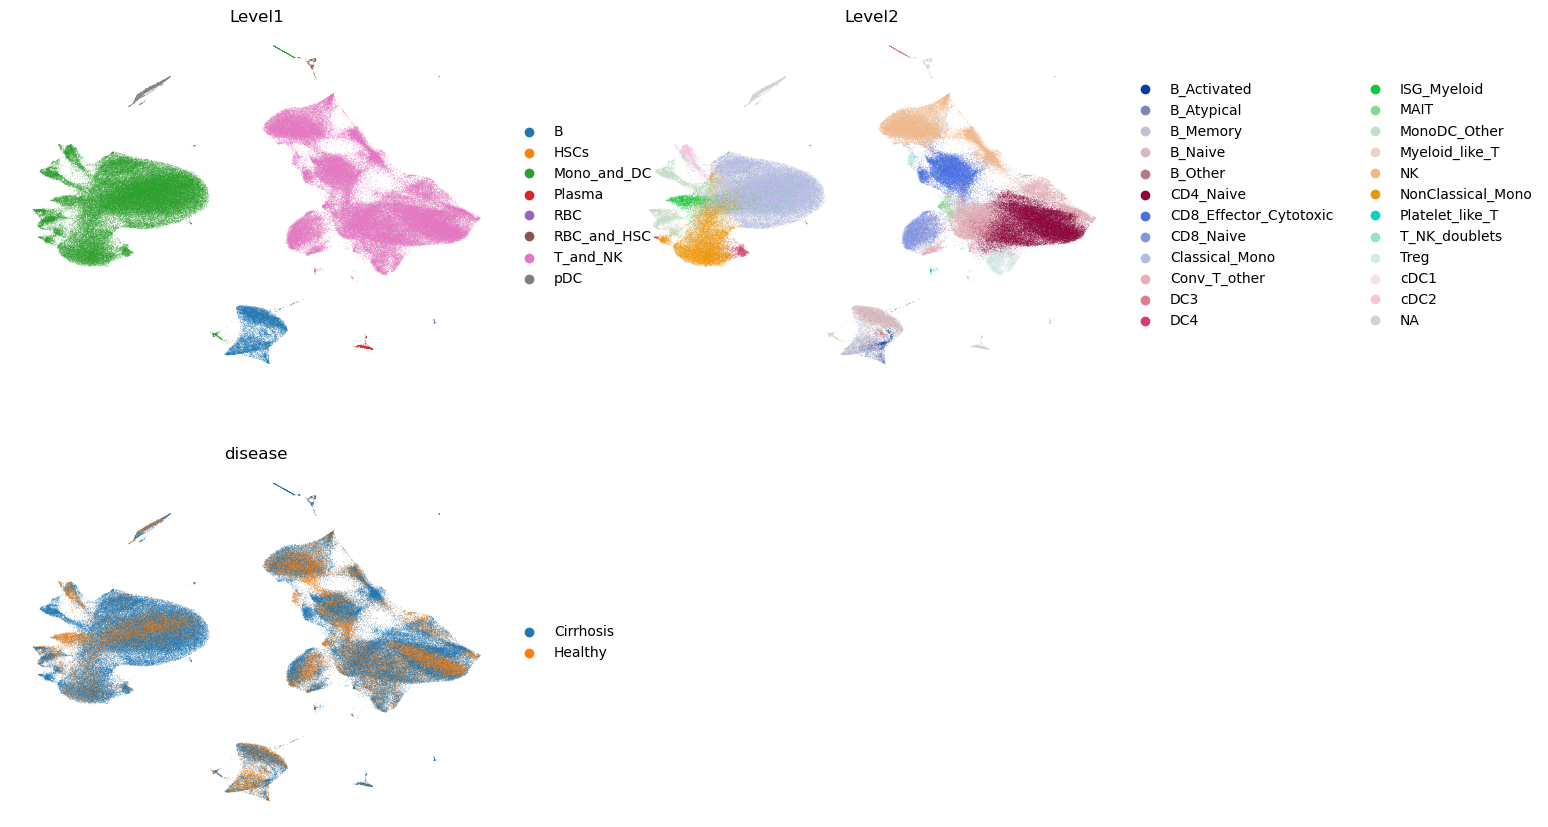

In [8]:
# Preparamos lista de variables para colorear el UMAP
color_vars = ["Level1"]
if "Level2" in adata_main.obs.columns:
    color_vars.append("Level2")

# Añadimos variables de interés si existen
for col in ["sample", "sample_id", "libraryID", "disease", "condition", "group"]:
    if col in adata_main.obs.columns:
        color_vars.append(col)

print("Variables que se usarán para colorear UMAP:", color_vars)

sc.pl.embedding(
    adata_main,
    basis=CONFIG["UMAP_KEY"],
    color=color_vars,
    ncols=2,
    frameon=False,
    save=f"_{'__'.join(color_vars[:4])}.png"  # guarda una versión básica
)

In [9]:
import sys

if str(MARKERS_DIR) not in sys.path:
    sys.path.insert(0, str(MARKERS_DIR))

try:
    import markers
except ImportError as e:
    raise ImportError(
        f"No se pudo importar 'markers.py' desde {MARKERS_DIR}.\n"
        f"Error original: {e}"
    )

geneMarkers_level1 = getattr(markers, "geneMarkers_level1", {})
geneMarkers_level2 = getattr(markers, "geneMarkers_level2", {})

print("Level1 definidos en geneMarkers_level1:")
for l1 in geneMarkers_level1.keys():
    print(f"- {l1}")

print("\nLevel1 disponibles en geneMarkers_level2:")
for l1 in geneMarkers_level2.keys():
    print(f"- {l1}")

Level1 definidos en geneMarkers_level1:
- B
- Plasma
- Mono_and_DC
- pDC
- T_and_NK
- UTC
- ILC
- Platelets
- RBC_and_HSC

Level1 disponibles en geneMarkers_level2:
- B
- Plasma
- Mono_and_DC
- pDC
- T_and_NK
- ILC
- Platelets
- RBC_and_HSC
- UTC


Generando dotplot global de marcadores Level1 (usando solo genes presentes)...
categories: B, HSCs, Mono_and_DC, etc.
var_group_labels: B, Plasma, Mono_and_DC, etc.


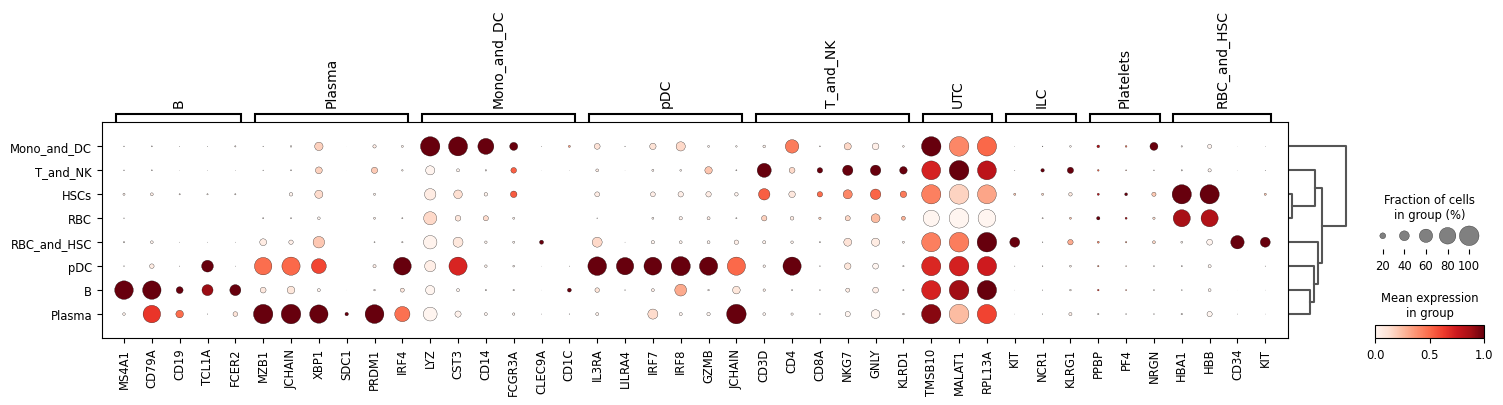

In [10]:
if geneMarkers_level1:
    # Construimos diccionario de var_names realmente presentes, igual que en el notebook 06
    varnames_level1 = {}
    for l1, genes in geneMarkers_level1.items():
        varnames = markers.symbols_to_varnames(adata_main, genes)
        if varnames:
            varnames_level1[l1] = varnames

    if varnames_level1:
        print("Generando dotplot global de marcadores Level1 (usando solo genes presentes)...")
        sc.pl.dotplot(
            adata_main,
            var_names=varnames_level1,
            groupby="Level1",
            standard_scale="var",
            dendrogram=True,
            save="_Level1_dotplot.png",
        )
    else:
        print(
            "[AVISO] Ninguno de los genes de geneMarkers_level1 se ha podido mapear a var_names; "
            "se omite el dotplot global de Level1."
        )
else:
    print("[AVISO] geneMarkers_level1 está vacío o no definido; se omite el dotplot global de Level1.")

Generando dotplot de Level2 para linaje 'B'...
categories: B_Activated, B_Atypical, B_Memory, etc.
var_group_labels: B_Naive, B_Memory, B_Immature, etc.


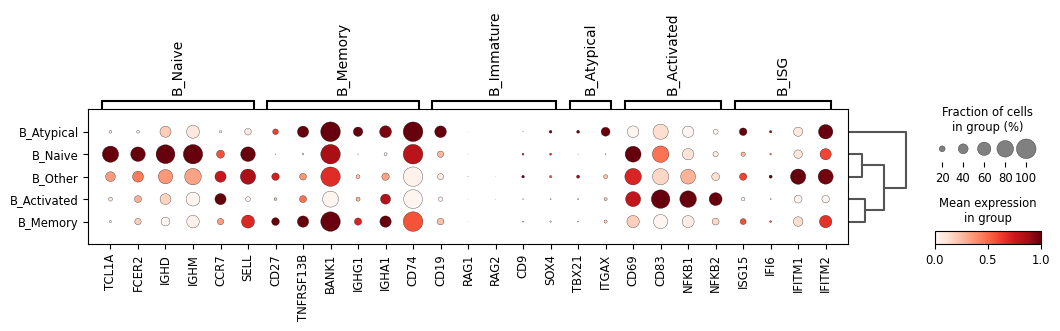

[INFO] Se omite dotplot L2 para 'HSCs' (sin Level2; población única).
Generando dotplot de Level2 para linaje 'Mono_and_DC'...
categories: Classical_Mono, DC3, DC4, etc.
var_group_labels: Classical_Mono, NonClassical_Mono, cDC1, etc.


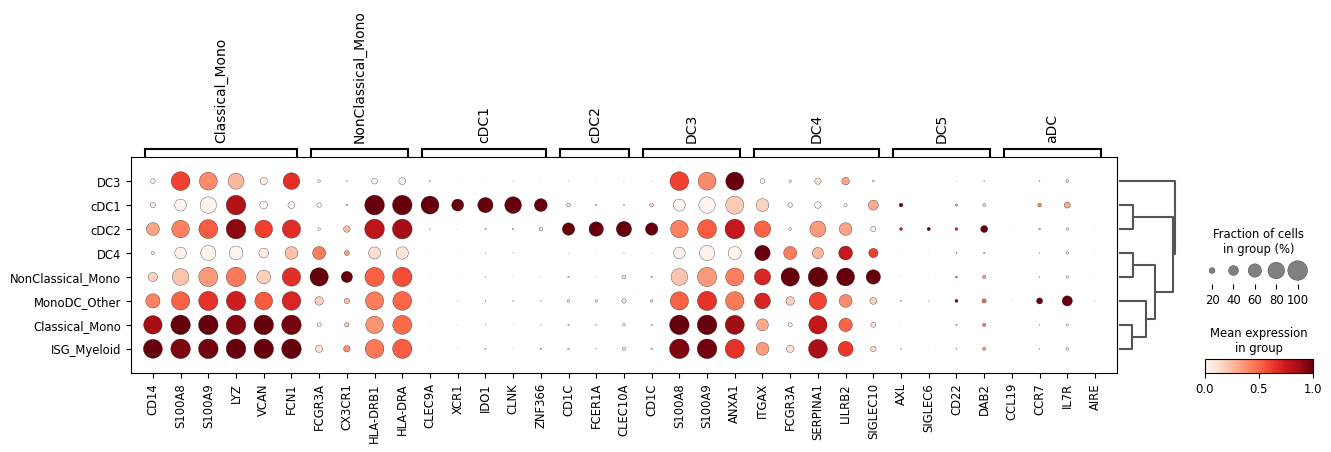

[INFO] Se omite dotplot L2 para 'Plasma' (sin Level2; población única).
[INFO] Se omite dotplot L2 para 'RBC' (sin Level2; población única).
[INFO] Se omite dotplot L2 para 'RBC_and_HSC' (sin Level2; población única).
Generando dotplot de Level2 para linaje 'T_and_NK'...
categories: CD4_Naive, CD8_Effector_Cytotoxic, CD8_Naive, etc.
var_group_labels: CD4_Naive, CD8_Naive, CD4_Effector_Th, etc.


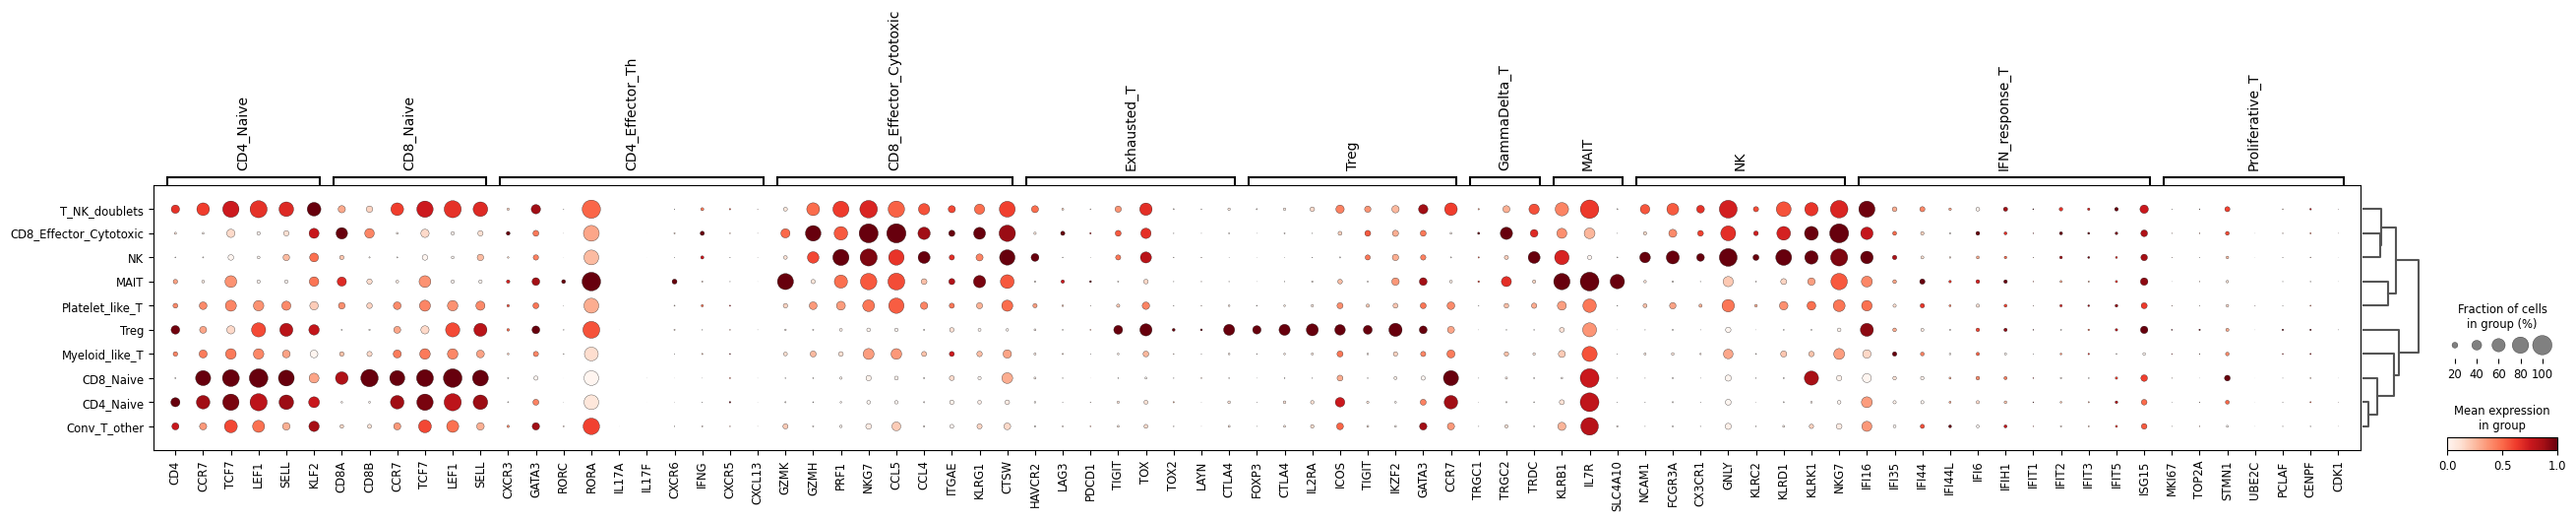

[INFO] Se omite dotplot L2 para 'pDC' (sin Level2; población única).


In [11]:
for l1 in level1_categories:
    # Solo hacemos dotplot L2 para los linajes con Level2 real
    if l1 not in LINEAGES_WITH_LEVEL2:
        print(f"[INFO] Se omite dotplot L2 para '{l1}' (sin Level2; población única).")
        continue

    if l1 not in geneMarkers_level2:
        print(f"[INFO] No hay paneles Level2 definidos para '{l1}' en geneMarkers_level2. Se omite dotplot L2 para este linaje.")
        continue

    # Subconjunto de células de este linaje
    mask = (adata_main.obs["Level1"] == l1).values
    adata_l1 = adata_main[mask].copy()

    if "Level2" not in adata_l1.obs.columns:
        print(f"[AVISO] El linaje '{l1}' no tiene 'Level2' definido en el objeto global. Se omite dotplot L2.")
        continue

    # Panel de genes de Level2 para este linaje (dict: Level2 -> [genes])
    panel_genes = geneMarkers_level2[l1]

    # Mapeamos cada lista de genes a var_names reales del subobjeto
    varnames_level2 = {}
    for l2_name, genes in panel_genes.items():
        varnames = markers.symbols_to_varnames(adata_l1, genes)
        if varnames:
            varnames_level2[l2_name] = varnames

    if not varnames_level2:
        print(
            f"[AVISO] Ningún gen del panel Level2 para '{l1}' se ha podido mapear a var_names; "
            "se omite el dotplot L2 para este linaje."
        )
        continue

    print(f"Generando dotplot de Level2 para linaje '{l1}'...")
    # Aseguramos que Level2 es categórico
    adata_l1.obs["Level2"] = adata_l1.obs["Level2"].astype("category")

    sc.pl.dotplot(
        adata_l1,
        var_names=varnames_level2,
        groupby="Level2",
        standard_scale="var",
        dendrogram=True,
        save=f"_Level2_{l1.replace(' ', '_')}_dotplot.png",
    )

In [12]:
SUMMARY_DIR = DATA_PROCESSED_DIR / "summary_tables"
SUMMARY_DIR.mkdir(exist_ok=True)

# Tabla Level1 x Level2
if "Level2" in adata_main.obs.columns:
    ctab_L1_L2 = pd.crosstab(adata_main.obs["Level1"], adata_main.obs["Level2"])
    path_L1_L2 = SUMMARY_DIR / "cell_counts_Level1_by_Level2.csv"
    ctab_L1_L2.to_csv(path_L1_L2)
    print("Guardada tabla de conteos Level1 x Level2 en:")
    print(" ", path_L1_L2)
else:
    print("[INFO] 'Level2' no está definido globalmente; se omite la tabla Level1 x Level2.")

# Tabla Level1 x sample (si existe alguna columna tipo sample)
sample_col = None
for cand in ["sample", "sample_id", "libraryID"]:
    if cand in adata_main.obs.columns:
        sample_col = cand
        break

if sample_col is not None:
    ctab_L1_sample = pd.crosstab(adata_main.obs["Level1"], adata_main.obs[sample_col])
    path_L1_sample = SUMMARY_DIR / f"cell_counts_Level1_by_{sample_col}.csv"
    ctab_L1_sample.to_csv(path_L1_sample)
    print(f"Guardada tabla de conteos Level1 x {sample_col} en:")
    print(" ", path_L1_sample)
else:
    print("[INFO] No se encontró columna de sample ('sample', 'sample_id' o 'libraryID'); se omite esta tabla.")

# Tabla Level1 x disease/condition (si existe)
disease_col = None
for cand in ["disease", "condition", "group"]:
    if cand in adata_main.obs.columns:
        disease_col = cand
        break

if disease_col is not None:
    ctab_L1_dis = pd.crosstab(adata_main.obs["Level1"], adata_main.obs[disease_col])
    path_L1_dis = SUMMARY_DIR / f"cell_counts_Level1_by_{disease_col}.csv"
    ctab_L1_dis.to_csv(path_L1_dis)
    print(f"Guardada tabla de conteos Level1 x {disease_col} en:")
    print(" ", path_L1_dis)
else:
    print("[INFO] No se encontró columna de disease/condition ('disease', 'condition', 'group'); se omite esta tabla.")

Guardada tabla de conteos Level1 x Level2 en:
  D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\summary_tables\cell_counts_Level1_by_Level2.csv
[INFO] No se encontró columna de sample ('sample', 'sample_id' o 'libraryID'); se omite esta tabla.
Guardada tabla de conteos Level1 x disease en:
  D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\summary_tables\cell_counts_Level1_by_disease.csv


In [13]:
main_annotated_path = DATA_PROCESSED_DIR / "TFM_CIRRHOSIS_main_annotated.h5ad"
adata_main.write_h5ad(main_annotated_path)

print("Objeto principal anotado guardado en:")
print(main_annotated_path)

Objeto principal anotado guardado en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\TFM_CIRRHOSIS_main_annotated.h5ad


In [14]:
adata_main.obs["Level1"].value_counts()

Level1
T_and_NK       118426
Mono_and_DC     88902
B               12110
pDC              1876
Plasma            608
RBC_and_HSC       344
RBC                84
HSCs               39
Name: count, dtype: int64

In [15]:
adata_main.obs["Level2"].value_counts(dropna=False).head(30)

Level2
Classical_Mono            54370
CD4_Naive                 36685
NK                        25529
Conv_T_other              23832
NonClassical_Mono         16942
CD8_Effector_Cytotoxic    16229
MonoDC_Other               8651
CD8_Naive                  8606
B_Naive                    6493
Treg                       4645
ISG_Myeloid                4246
B_Memory                   3095
NaN                        2951
cDC2                       2800
MAIT                       1576
DC4                        1215
B_Atypical                 1125
B_Other                     799
B_Activated                 598
T_NK_doublets               589
Platelet_like_T             583
DC3                         543
Myeloid_like_T              152
cDC1                        135
Name: count, dtype: int64

In [16]:
# ============================================================
# QA FINAL — Consistencia Level2 tras aplicar LEVEL2_MAP
# (No modifica el objeto; solo imprime checks y posibles alertas)
# ============================================================

print("\n" + "="*80)
print("QA FINAL — Level2 / Type_L1L2 (post-LEVEL2_MAP)")
print("="*80)

# 0) Resumen básico
print("\n[0] Resumen básico")
print("  n_obs global:", adata_main.n_obs)
print("  Level1 únicos:", adata_main.obs["Level1"].nunique())
print("  Level2 únicos (incluyendo NaN):", adata_main.obs["Level2"].nunique(dropna=False))
print("  Type_L1L2 únicos:", adata_main.obs["Type_L1L2"].nunique())

# 1) Cobertura: cuántas células tienen Level2
print("\n[1] Cobertura de Level2")
n_l2 = adata_main.obs["Level2"].notna().sum()
print(f"  Células con Level2 asignado: {n_l2} / {adata_main.n_obs} ({100*n_l2/adata_main.n_obs:.2f}%)")
print("  NaN en Level2:", adata_main.obs["Level2"].isna().sum())

# 2) ¿Se han colado clusters numéricos por falta de mapping?
print("\n[2] Labels numéricas en Level2 (indicador de mapping incompleto)")
l2_str = adata_main.obs["Level2"].astype(str)
is_numeric = l2_str.str.fullmatch(r"\d+").fillna(False)
n_numeric = int(is_numeric.sum())
print("  Nº celdas con Level2 numérico:", n_numeric)
if n_numeric > 0:
    print("  [ALERTA] Hay Level2 numéricos. Ejemplos:")
    print(adata_main.obs.loc[is_numeric, ["Level1","Level2"]].head(20))

# 3) Crosstab Level1 x Level2 (top por linaje)
print("\n[3] Crosstab Level1 x Level2 (top 10 por Level1)")
ct = pd.crosstab(adata_main.obs["Level1"], adata_main.obs["Level2"], dropna=False)

for l1 in LINEAGES_WITH_LEVEL2:
    if l1 in ct.index:
        top = ct.loc[l1].sort_values(ascending=False).head(15)
        print(f"\n  -- {l1} (top) --")
        print(top[top > 0])

# 4) Universe check: categorías esperadas vs observadas (solo linajes con Level2 real)
print("\n[4] Universe check (solo linajes con Level2 real)")
for l1 in LINEAGES_WITH_LEVEL2:
    obs_l2 = sorted(
        adata_main.obs.loc[adata_main.obs["Level1"] == l1, "Level2"]
        .dropna().astype(str).unique().tolist()
    )
    map_l2 = sorted(set(LEVEL2_MAP.get(l1, {}).values()))
    print(f"\n  Linaje: {l1}")
    print("   - Observadas en global:", obs_l2)
    print("   - En LEVEL2_MAP:", map_l2)

# 5) Tamaños de categorías "sensibles" (contaminación / doublets / Other)
print("\n[5] Tamaños de categorías sensibles (si existen)")
sensitive = [
    "Conv_T_other", "T_NK_doublets", "Platelet_like_T", "Myeloid_like_T",
    "MonoDC_Other", "ISG_Myeloid", "B_Other"
]
l2_vals = adata_main.obs["Level2"].dropna().astype(str)
for lab in sensitive:
    if lab in set(l2_vals.unique()):
        n = int((l2_vals == lab).sum())
        print(f"  {lab:>18}: {n}")

# 6) Si existe patientID: dominancia por paciente dentro de cada Level2 (top 10)
print("\n[6] Dominancia por patientID dentro de Level2 (si existe)")
if "patientID" in adata_main.obs.columns and adata_main.obs["Level2"].notna().any():
    tmp = pd.crosstab(adata_main.obs["Level2"], adata_main.obs["patientID"], normalize="index").max(1)
    print(tmp.sort_values(ascending=False).head(15))
else:
    print("  (patientID no disponible o Level2 vacío)")

# 7) Si existe scrublet: proporción de doublets por Level2 (top 15)
print("\n[7] Scrublet vs Level2 (si existe)")
if "scrublet_predicted_doublet" in adata_main.obs.columns and adata_main.obs["Level2"].notna().any():
    tab = pd.crosstab(adata_main.obs["Level2"], adata_main.obs["scrublet_predicted_doublet"], normalize="index")
    print(tab.head(20))
else:
    print("  (scrublet_predicted_doublet no disponible o Level2 vacío)")

print("\nQA FINAL completado.")
print("="*80)


QA FINAL — Level2 / Type_L1L2 (post-LEVEL2_MAP)

[0] Resumen básico
  n_obs global: 222389
  Level1 únicos: 8
  Level2 únicos (incluyendo NaN): 24
  Type_L1L2 únicos: 28

[1] Cobertura de Level2
  Células con Level2 asignado: 219438 / 222389 (98.67%)
  NaN en Level2: 2951

[2] Labels numéricas en Level2 (indicador de mapping incompleto)
  Nº celdas con Level2 numérico: 0

[3] Crosstab Level1 x Level2 (top 10 por Level1)

  -- B (top) --
Level2
B_Naive        6493
B_Memory       3095
B_Atypical     1125
B_Other         799
B_Activated     598
Name: B, dtype: int64

  -- T_and_NK (top) --
Level2
CD4_Naive                 36685
NK                        25529
Conv_T_other              23832
CD8_Effector_Cytotoxic    16229
CD8_Naive                  8606
Treg                       4645
MAIT                       1576
T_NK_doublets               589
Platelet_like_T             583
Myeloid_like_T              152
Name: T_and_NK, dtype: int64

  -- Mono_and_DC (top) --
Level2
Classical_Mono 

In [17]:
# ============================================================
# EXTRA QA PARA DECIDIR SI NBXX ROMPERÁ ALGO (run al final de NB09)
# - Solo lecturas/contajes: NO modifica el objeto
# - Objetivo: ver si NBXX (listas T_L2/NK_L2/MONO_L2/DC_L2 + fills) encaja con tu Level2 actual
# ============================================================

import pandas as pd
import numpy as np

# --- elegir objeto correcto ---
if "adata_main" in globals():
    A = adata_main
elif "adata" in globals():
    A = adata
else:
    raise NameError("No encuentro 'adata_main' ni 'adata' en memoria. Ejecuta antes la celda donde cargas/creas el objeto global.")

print("=== EXTRA QA post-NB09 ===")
print("n_obs:", A.n_obs)

# checks mínimos
for col in ["Level1", "Level2"]:
    if col not in A.obs.columns:
        raise KeyError(f"Falta columna '{col}' en A.obs")

# --- 1) NA en Level2 por Level1 (clave para el fill de NBXX) ---
tmp = A.obs[["Level1","Level2"]].copy()
tmp["Level2_isNA"] = tmp["Level2"].isna()
na_by_l1 = tmp.groupby("Level1")["Level2_isNA"].sum().sort_values(ascending=False)

print("\n[1] NA en Level2 por Level1 (top):")
print(na_by_l1.head(30))
print("Total NA Level2:", int(tmp["Level2_isNA"].sum()))

# --- 2) Universo real de Level2 (para comparar con listas hardcodeadas de NBXX) ---
l2_present = sorted(pd.Series(A.obs["Level2"]).dropna().astype(str).unique().tolist())
print("\n[2] Level2 presentes (sin NA) ->", len(l2_present))
print(l2_present)

# --- 3) Crosstab Level1 x Level2 (para detectar incoherencias) ---
ct = pd.crosstab(A.obs["Level1"].astype(str), A.obs["Level2"], dropna=False)
print("\n[3] Crosstab Level1 x Level2 (top por fila):")
for l1 in ct.index:
    s = ct.loc[l1]
    s = s[s > 0].sort_values(ascending=False)
    print(f"\n-- {l1} --")
    print(s.head(40))

# --- 4) Simulación NBXX: ¿qué Level2 quedarían SIN mapear a Level1_refined?
T_L2 = [
    "CD4_Naive","CD8_Naive","CD8_Effector_Cytotoxic","Conv_T_other",
    "MAIT","GammaDelta_T","Treg","Proliferative_T","Exhausted_T",
]
NK_L2 = ["NK"]
MONO_L2 = ["Classical_Mono","NonClassical_Mono","ISG_Myeloid","MonoDC_Other"]
DC_L2   = ["cDC1","cDC2","DC4","aDC"]

obs = A.obs[["Level1","Level2"]].copy()
obs["Level1"] = obs["Level1"].astype(str)
mask_l2_na = obs["Level2"].isna().to_numpy()
obs["Level2"] = obs["Level2"].astype(str)

mask_TNK = (obs["Level1"].values == "T_and_NK") & (~mask_l2_na)
mask_MDC = (obs["Level1"].values == "Mono_and_DC") & (~mask_l2_na)

mask_T    = mask_TNK & np.isin(obs["Level2"].values, T_L2)
mask_NK   = mask_TNK & np.isin(obs["Level2"].values, NK_L2)
mask_Mono = mask_MDC & np.isin(obs["Level2"].values, MONO_L2)
mask_DC   = mask_MDC & np.isin(obs["Level2"].values, DC_L2)

unmapped_TNK = int(mask_TNK.sum() - mask_T.sum() - mask_NK.sum())
unmapped_MDC = int(mask_MDC.sum() - mask_Mono.sum() - mask_DC.sum())

print("\n[4] Simulación NBXX Level1_refined (estimación 'unmapped'):")
print("T_and_NK total (Level2 no-NA):", int(mask_TNK.sum()))
print(" - mapearían a 'T' :", int(mask_T.sum()))
print(" - mapearían a 'NK':", int(mask_NK.sum()))
print(" - sin map (seguirían 'T_and_NK'):", unmapped_TNK)

print("\nMono_and_DC total (Level2 no-NA):", int(mask_MDC.sum()))
print(" - mapearían a 'Mono':", int(mask_Mono.sum()))
print(" - mapearían a 'DC'  :", int(mask_DC.sum()))
print(" - sin map (seguirían 'Mono_and_DC'):", unmapped_MDC)

# --- 5) Qué Level2 dentro de T_and_NK / Mono_and_DC NO están en las listas de NBXX ---
l2_tnk = sorted(pd.Series(A.obs.loc[A.obs["Level1"].astype(str)=="T_and_NK","Level2"]).dropna().astype(str).unique())
l2_mdc = sorted(pd.Series(A.obs.loc[A.obs["Level1"].astype(str)=="Mono_and_DC","Level2"]).dropna().astype(str).unique())

unknown_in_TNK = sorted(set(l2_tnk) - set(T_L2) - set(NK_L2))
unknown_in_MDC = sorted(set(l2_mdc) - set(MONO_L2) - set(DC_L2))

print("\n[5] Level2 en T_and_NK NO cubiertos por listas NBXX:", unknown_in_TNK)
print("[5] Level2 en Mono_and_DC NO cubiertos por listas NBXX:", unknown_in_MDC)

print("\n[OK] EXTRA QA completado.")

=== EXTRA QA post-NB09 ===
n_obs: 222389

[1] NA en Level2 por Level1 (top):
Level1
pDC            1876
Plasma          608
RBC_and_HSC     344
RBC              84
HSCs             39
B                 0
Mono_and_DC       0
T_and_NK          0
Name: Level2_isNA, dtype: int64
Total NA Level2: 2951

[2] Level2 presentes (sin NA) -> 23
['B_Activated', 'B_Atypical', 'B_Memory', 'B_Naive', 'B_Other', 'CD4_Naive', 'CD8_Effector_Cytotoxic', 'CD8_Naive', 'Classical_Mono', 'Conv_T_other', 'DC3', 'DC4', 'ISG_Myeloid', 'MAIT', 'MonoDC_Other', 'Myeloid_like_T', 'NK', 'NonClassical_Mono', 'Platelet_like_T', 'T_NK_doublets', 'Treg', 'cDC1', 'cDC2']

[3] Crosstab Level1 x Level2 (top por fila):

-- B --
Level2
B_Naive        6493
B_Memory       3095
B_Atypical     1125
B_Other         799
B_Activated     598
Name: B, dtype: int64

-- HSCs --
Series([], Name: HSCs, dtype: int64)

-- Mono_and_DC --
Level2
Classical_Mono       54370
NonClassical_Mono    16942
MonoDC_Other          8651
ISG_Myeloid      

C:\Users\Coni\AppData\Local\Temp\ipykernel_11092\3882783931.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  na_by_l1 = tmp.groupby("Level1")["Level2_isNA"].sum().sort_values(ascending=False)



[4] Simulación NBXX Level1_refined (estimación 'unmapped'):
T_and_NK total (Level2 no-NA): 118426
 - mapearían a 'T' : 91573
 - mapearían a 'NK': 25529
 - sin map (seguirían 'T_and_NK'): 1324

Mono_and_DC total (Level2 no-NA): 88902
 - mapearían a 'Mono': 84209
 - mapearían a 'DC'  : 4150
 - sin map (seguirían 'Mono_and_DC'): 543

[5] Level2 en T_and_NK NO cubiertos por listas NBXX: ['Myeloid_like_T', 'Platelet_like_T', 'T_NK_doublets']
[5] Level2 en Mono_and_DC NO cubiertos por listas NBXX: ['DC3']

[OK] EXTRA QA completado.


### Comentario de QC – Notebook 09 (post-Harmony, `TFM_CIRRHOSIS_main_annotated.h5ad`)

Este comentario resume los controles de calidad realizados sobre el objeto global anotado en NB09 tras corregir el clustering por linaje (NB07) con Harmony. Sirve como **cierre técnico del NB09** y como recordatorio de puntos a vigilar para el downstream (NB10+).

---

#### 1. Integración de Level2 y `Type_L1L2` (post-`LEVEL2_MAP`)

- **Cobertura de Level2**:
  - `Level2` asignado a **219,438 / 222,389** células (**98.67%**).
  - Quedan **2,951 NaN** en `Level2`, consistente con que solo ciertos linajes tienen Level2 detallado (los demás quedan como “población única” a nivel Level1 y se tratan downstream).

- **Calidad del mapeo**:
  - **0 etiquetas numéricas** (no hay `"0"`, `"1"`, etc.) en `Level2` → indica que el `LEVEL2_MAP` cubre completamente los clusters L2 integrados.
  - El “universo” de etiquetas observadas en `Level2` **coincide exactamente** con el universo definido en `LEVEL2_MAP` para los 3 linajes con Level2 real (`B`, `T_and_NK`, `Mono_and_DC`).

- **`Type_L1L2`**:
  - Se generan **28 categorías** de `Type_L1L2` (8 Level1, 24 Level2 incluyendo NaN), sin señales de incoherencia por categorías inesperadas.

> **Conclusión:** La integración de Level2 desde los objetos por linaje y el uso del `LEVEL2_MAP` actualizado (post-Harmony) es técnicamente correcta: no hay pérdida masiva de células, no hay IDs numéricos “colados”, y el universo de etiquetas es consistente.

---

#### 2. Coherencia Level1 × Level2 (crosstab)

- **B** (Level2 observados):  
  `B_Naive` 6,493; `B_Memory` 3,095; `B_Atypical` 1,125; `B_Activated` 598; `B_Other` 799.  
  → Universo de B consistente y compacto.

- **T_and_NK** (Level2 observados):  
  `CD4_Naive` 36,685; `NK` 25,529; `Conv_T_other` 23,832; `CD8_Effector_Cytotoxic` 16,229; `CD8_Naive` 8,606; `Treg` 4,645; `MAIT` 1,576; `T_NK_doublets` 589; `Platelet_like_T` 583; `Myeloid_like_T` 152.  
  → Se preservan explícitamente categorías de contaminación/doublets esperadas por downstream.

- **Mono_and_DC** (Level2 observados):  
  `Classical_Mono` 54,370; `NonClassical_Mono` 16,942; `MonoDC_Other` 8,651; `ISG_Myeloid` 4,246; `cDC2` 2,800; `DC4` 1,215; `DC3` 543; `cDC1` 135.  
  → Universo de subtipos coherente con el mapa y con la estructura legacy (incluye `ISG_Myeloid` y `MonoDC_Other`).

> **Conclusión:** No hay “subtipos fuera de su linaje”: las etiquetas Level2 aparecen en el Level1 esperado.

---

#### 3. Categorías “sensibles” (doublet-like / contaminaciones / Other)

Tamaños globales:
- `Conv_T_other`: **23,832**
- `T_NK_doublets`: **589**
- `Platelet_like_T`: **583**
- `Myeloid_like_T`: **152**
- `MonoDC_Other`: **8,651**
- `ISG_Myeloid`: **4,246**
- `B_Other`: **799**

Estas categorías eran parte del espíritu del pipeline legacy (clusters “no puros” que luego se gestionan en notebooks downstream). En el pipeline post-Harmony, siguen existiendo y con tamaños razonables.

---

#### 4. Scrublet vs Level2 (validación indirecta de doublets)

La distribución de `scrublet_predicted_doublet` es coherente con el uso downstream de categorías “doublet-like”:
- `T_NK_doublets`: **~0.776 True** (muy enriquecido en doublets) → valida la etiqueta.
- `B_Other`: **~0.457 True**, `MonoDC_Other`: **~0.353 True** → consistente con mezclas/contaminación.
- `Myeloid_like_T`: **~0.072 True** (y N pequeño) → categoría rara, a vigilar pero no contradictoria.

> **Conclusión:** Scrublet apoya que las clases “doublet/other” capturan artefactos reales que el legacy también trataba.

---

#### 5. Variabilidad por paciente (banderas a vigilar, no “errores”)

Se observa dominancia por `patientID` particularmente alta en:
- `DC3`: **max ≈ 0.823** (posible población muy paciente-específica o artefacto residual)
- `B_Activated`: **max ≈ 0.543**

> **Implicación para NB10+:** Las comparaciones deben hacerse **por paciente** (proporciones por muestra) y no solo por pooling global, y conviene revisar que resultados de poblaciones raras no estén dominados por 1 individuo.

---

#### 6. Diferencias importantes vs QC legacy (sin cambiar el diseño)

- En legacy, `Level2` tenía 0 NaN porque se “completaba” el universo de poblaciones simples (Plasma/pDC/RBC/HSC/etc.).  
  En post-Harmony, hay NaN en `Level2` para linajes sin Level2 detallado en NB07–08. Esto no invalida NB09, pero implica que **el rellenado final de Level2 para poblaciones simples (si se desea) debe ocurrir en notebooks downstream** (p.ej. limpieza final / Level2_final).

- El universo de T/NK aquí no incluye explícitamente `GammaDelta_T`, `Proliferative_T` o `Exhausted_T` (presentes en legacy).  
  Esto no es un “fallo”, pero **cualquier notebook downstream que asuma esas etiquetas debe revisarse** (o bien porque ya no existen como clusters separados, o porque se capturan dentro de buckets más amplios).

---

#### 7. Conclusión general del QC post-Harmony

- La anotación **Level1 + Level2** del objeto global es **coherente** con el mapa actualizado y los checks técnicos (sin IDs numéricos, universo consistente, tamaños razonables).
- Las categorías “problemáticas” (doublets/contaminación) siguen presentes y **están respaldadas por Scrublet**.
- Hay señales de **heterogeneidad por paciente** en poblaciones raras (especialmente `DC3`), que deben considerarse explícitamente en NB10+.

> **Estado final NB09 (post-Harmony):** Objeto global anotado listo para downstream, con la nota de que el “completado” de etiquetas para poblaciones simples y/o la normalización de universos legacy (si se requiere) se gestionará downstream (p.ej. Level2_final / limpieza final).
